In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## model

In [2]:
 # Encoder
class encoder(nn.Module):
  def __init__(self):
    super(encoder, self).__init__()

    self.fc1 = nn.Linear(784, 512)

    self.fc2 = nn.Linear(512, 2)
    self.fc3 = nn.Linear(512, 2)

    self.N=torch.distributions.Normal(0,1) # normal gaussian
    self.N.loc=self.N.loc.to(device)
    self.N.scale=self.N.scale.to(device)
    self.kl=0
  def forward(self, x):
    x=torch.flatten(x,start_dim=1)

    x=F.relu(self.fc1(x))

    mu = self.fc2(x)

    sigma=torch.exp(self.fc3(x))
    #reparametrization trick
    z=  mu+sigma*self.N.sample(mu.shape)
    self.kl=torch.sum(sigma**2 + mu**2-torch.log(sigma)-1/2).sum()  # the KL
    return z

    # Decoder

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc1=nn.Linear(2,512)
    self.fc2=nn.Linear(512,784)

  def forward(self,z):
    z=F.relu(self.fc1(z))
    z=torch.sigmoid(self.fc2(z))
    return z.reshape(-1,1,28,28)

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder=encoder()
    self.decoder=Decoder()

  def forward(self,x):
    z=self.encoder(x)
    x_reconst=self.decoder(z)
    return x_reconst



## MNIST DATASET

In [3]:
Train_dataset=torchvision.datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
Test_dataset=torchvision.datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)
Train_loader=torch.utils.data.DataLoader(dataset=Train_dataset,batch_size=100,shuffle=True)
Test_loader=torch.utils.data.DataLoader(dataset=Test_dataset,batch_size=100,shuffle=False)


## Training function

In [4]:
from re import A
def  train(vae,Train_dataset,epochs=20):
  optimizer=optim.Adam(vae.parameters(),lr=1e-3)

  num_epochs = 200
  print_per = 100

  loss_record = [] # ELBO
  KL_loss = [] # KL Divergence
  AVG_loss = [] # Saving per epoch loss
  AVG_KL_loss = [] # saving per ep

  for epoch in range(num_epochs):
    train_loss=0
    print_loss=0
    kl_loss=0
    for x,y in Train_loader:
      x=x.to(device)
      optimizer.zero_grad()
      x_hat=vae(x)
      BCE=F.binary_cross_entropy(x_hat,x,reduction='sum')
      KLD=vae.encoder.kl
      loss=BCE+KLD

      loss.backward()
      if(epoch==0):
        loss_record.append(loss.item())
        KL_loss.append(KLD.item())
      train_loss+=loss.item()
      print_loss+=loss.item()
      kl_loss+=KLD.item()
      optimizer.step()
  AVG_loss.append(train_loss/len(Train_dataset))
  AVG_KL_loss.append(kl_loss/len(Train_dataset))

  return KL_loss,loss_record,AVG_KL_loss,AVG_loss


## Plotting Loss

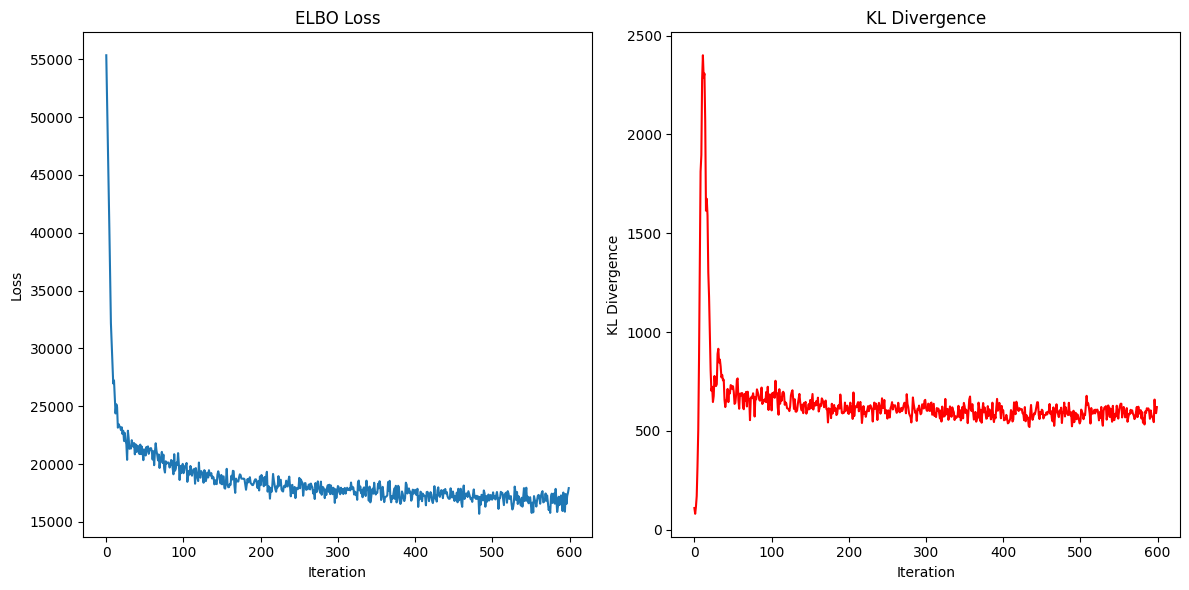

In [5]:
vae=VAE().to(device)
KL_loss, loss_record, AVG_KL_loss, AVG_loss = train(vae,Train_dataset)

# Plotting the loss and KL divergence
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_record)
plt.title("ELBO Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(KL_loss,color='red')
plt.title("KL Divergence")
plt.xlabel("Iteration")
plt.ylabel("KL Divergence")

plt.tight_layout()
plt.savefig('EBO&KL.png')
plt.show()


## Reconstruction and Performance

In [6]:
#testing reconstruction
def reconstruct_images(vae,data_loader,n_images):
  real_images,reconstructed_images=[],[]
  vae.eval()
  with torch.no_grad():
    for x,y in data_loader:
      x=x.to(device)
      x_hat=vae(x)
      real_images.append(x)
      reconstructed_images.append(x_hat)
      break
  return torch.cat(real_images[:n_images]),torch.cat(reconstructed_images[:n_images])

def generate_images(vae,n_images):
  vae.eval()
  with torch.no_grad():
    z=torch.randn(n_images,2).to(device)
    generated_images=vae.decoder(z)
  return generated_images

def display_image(real_images,reconstructed_images,generated_images):
  real_images=make_grid(real_images,nrow=5,normalize=True)
  reconstructed_images=make_grid(reconstructed_images,nrow=5,normalize=True)
  generated_images=make_grid(generated_images,nrow=5,normalize=True)
  plt.figure(figsize=(15,10))
  plt.subplot(1,3,1)
  plt.imshow(real_images.permute(1,2,0).cpu())
  plt.title("Real Images")
  plt.subplot(1,3,2)
  plt.imshow(reconstructed_images.permute(1,2,0).cpu())
  plt.title("Reconstructed Images")
  plt.subplot(1,3,3)
  plt.imshow(generated_images.permute(1,2,0).cpu())
  plt.title("Generated Images")
  plt.tight_layout()
  plt.axis('off')
  plt.savefig('reconstructedvae.png')
  plt.show()

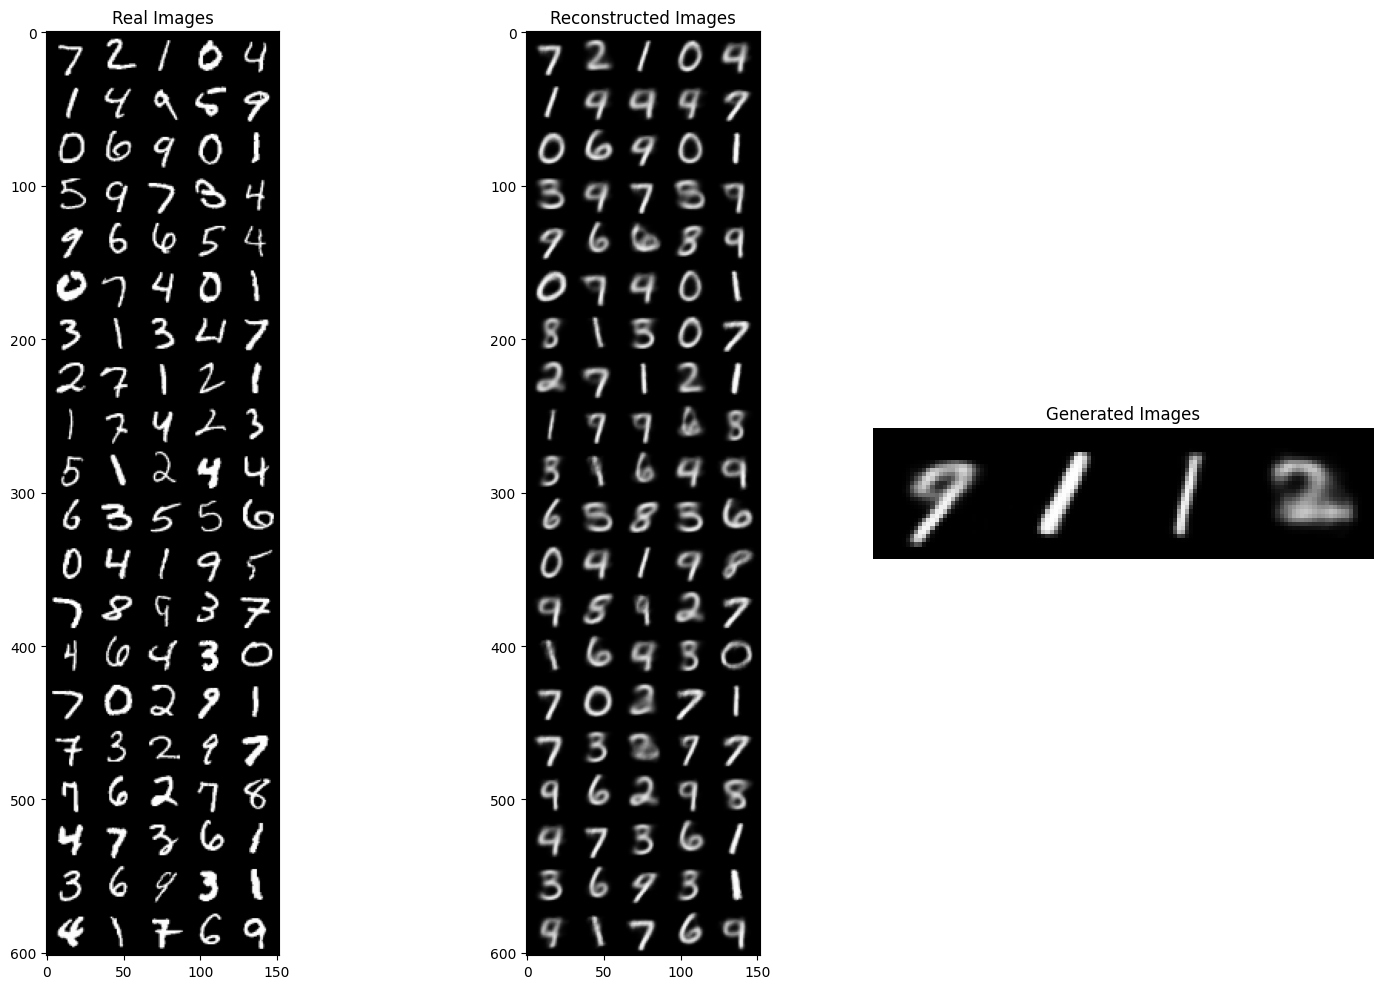

In [7]:
n_images=4
real_images,reconstructed_images=reconstruct_images(vae,Test_loader,n_images)
generated_imgs=generate_images(vae,n_images) # Call the generate_images function
display_image(real_images,reconstructed_images,generated_imgs) # Call the display_image

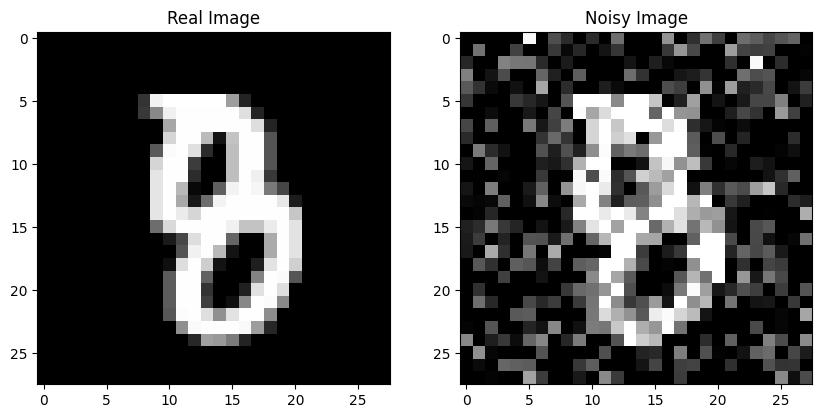

In [8]:
#Anomaly detection
def add_noise(images,noise_factor=0.3):
  noisy_images=images+torch.randn_like(images)*noise_factor
  noisy_images=torch.clip(noisy_images,0.,1.)
  return noisy_images

# generate noram and noisy
test_real, test_recon=reconstruct_images(vae,Train_loader,n_images=1)
noise_real=add_noise(test_real)
# plott
fig,axes=plt.subplots(ncols=2,figsize=(10,5))
axes[0].imshow(np.squeeze(test_real[0].permute(1,2,0).cpu()),cmap='gray')
axes[0].set_title("Real Image")
axes[1].imshow(np.squeeze(noise_real[0].permute(1,2,0).cpu()),cmap='gray')
axes[1].set_title("Noisy Image")
plt.savefig("corrupted.png")
plt.show()

In [9]:
def add_noise(images,noise_factor=0.5):
  noisy_images=images+torch.randn_like(images)*noise_factor
  noisy_images=torch.clip(noisy_images,0.,1.)
  return noisy_images

def reconstruction_err(vae,images):
  original_shape=images.shape
  images=images.to(torch.float32).reshape(-1,28*28)
  with torch.no_grad():
    reconstructed_images=vae(images)
    error=torch.mean((images.reshape(original_shape)-reconstructed_images)**2,dim=1)
  return error.cpu().numpy()

def anomaly_detection(vae,data_loader,noise_factor=0.3):
   normal_errors=[]
   anomaly_errors=[]
   vae.eval()
   if len(data_loader)==0:
     raise ValueError("Data loader is empty")

   for x,y in data_loader:
     x=x.to(device)
     errors=reconstruction_err(vae,x)
     normal_errors.extend(errors)

   for x,y in data_loader:
     x=x.to(device)
     x_noisy=add_noise(x,noise_factor)
     errors=reconstruction_err(vae,x_noisy)
     anomaly_errors.extend(errors)
     if len(anomaly_errors)>=len(normal_errors):
       break
   return np.array(normal_errors).flatten(),np.array(anomaly_errors).flatten()

In [10]:
#plot the distribution of the errors
def plot_distribution(normal_errors,anomaly_errors,threshold_value):
  plt.figure(figsize=(10,5))
  plt.hist(normal_errors.flatten(),bins=50,alpha=0.5,label='Normal')
  plt.hist(anomaly_errors.flatten(),bins=50,alpha=0.5,label='Anomaly')
  plt.axvline(x=threshold_value,color='r',linestyle='--',label='Threshold')
  plt.xlabel('Reconstruction Error')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

def anomaly_classfier(errors,threshold_value):
  anomaly_mask=errors>threshold_value
  return anomaly_mask

In [ ]:
normal_errors,anomaly_errors=anomaly_detection(vae,Train_loader)


threshold_value=9*np.mean(normal_errors)+np.std(normal_errors)


plot_distribution(normal_errors,anomaly_errors,threshold_value)
print(f"Threshold value: {threshold_value}")

normal_anomaly=anomaly_classfier(normal_errors,threshold_value)
anomaly_anomaly=anomaly_classfier(anomaly_errors,threshold_value)

normal_detection_rate=100*np.sum(normal_anomaly)/len(normal_anomaly)
anomaly_detection_rate=100*np.sum(anomaly_anomaly)/len(anomaly_anomaly)
print(f"Normal Detection Rate: {normal_detection_rate}")
print(f"Anomaly Detection Rate: {anomaly_detection_rate}")

## Latent space visualization

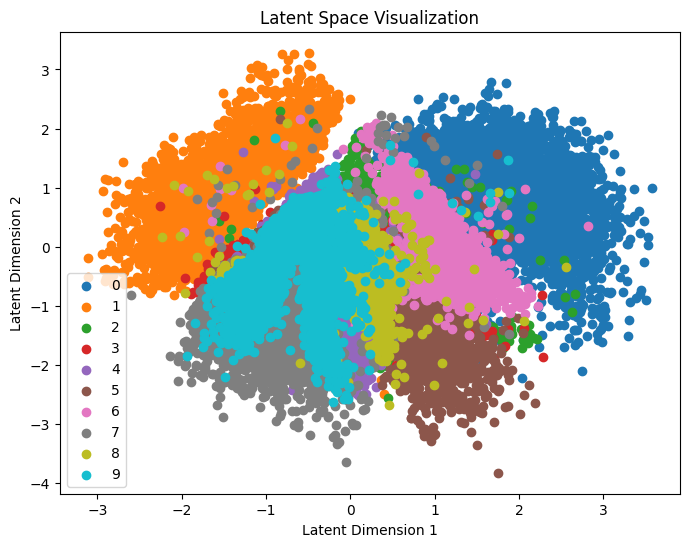

In [12]:

latent_representations = []
labels = []

for images, label in Train_loader:
  images = images.to(device)
  with torch.no_grad():
    z = vae.encoder(images)
    latent_representations.extend(z.cpu().numpy())
    labels.extend(label.numpy())

latent_representations = np.array(latent_representations)
labels = np.array(labels)

# Now you can plot the latent space representations with different colors for each class

plt.figure(figsize=(8, 6))
for i in range(10): # Assuming you have 10 classes (MNIST)
  plt.scatter(latent_representations[labels == i, 0],
              latent_representations[labels == i, 1],
              label=str(i))

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.legend()
plt.savefig('latent.png')
plt.show()